# Симуляция торговых сигналов

In [224]:
import pandas as pd
import numpy as np

Загрузка 5 минутных данных из файла

In [225]:
df = pd.read_csv('df_m5_TVI_CCI_T3_GHL.csv')
df['tradedate'] = pd.to_datetime(df['tradedate'])
# df.set_index('tradedate', inplace=True)  # Индекс должен быть временной меткой
df

,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,100.00,0,0,0,0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,100.00,1,0,1,0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,100.00,1,0,1,0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,100.00,1,0,1,0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,100.00,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
410502,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,43.72,1,1,1,1
410503,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,43.74,1,1,1,1
410504,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,43.86,1,1,1,1
410505,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,44.03,1,1,1,1


Создание дата фрейма с колонкой признаков открытия позиции Bay или Sell.

In [226]:
# # Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
# df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# # # Проверка, является ли текущая строка второй подряд с теми же значениями сигналов
# # df['SecondInRow'] = df['IsAllSame'] & df['IsAllSame'].shift(1).fillna(False)

# # Отмечаем только вторую строку в последовательности
# df['SecondInRow'] = (
#     df['IsAllSame'] &  # Текущая строка True
#     df['IsAllSame'].shift(1).fillna(False).astype(bool)  # Предыдущая строка True
# )

# # Создаем колонку 'sig' с условиями
# df['sig'] = 0  # Инициализируем с нулями
# df.loc[df['IsAllSame'] & df['SecondInRow'], 'sig'] = 1  # Записываем 1 при выполнении условий

# # Сохранение в файл
# df.to_csv("signal.csv", index=True)

# # Результат
# print(df)


In [227]:
# Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | \
    df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# Находим группы последовательных строк, где IsAllSame == True
df['Group'] = (df['IsAllSame'] != df['IsAllSame'].shift(1)).cumsum()

# Отмечаем только вторую строку в каждой группе, где IsAllSame == True
df['SecondInRow'] = df.groupby('Group').cumcount() == 1
df.loc[~df['IsAllSame'], 'SecondInRow'] = False  # Убираем строки, где IsAllSame == False

# Добавляем колонку 'sig', отмечаем только вторую строку в последовательности
df['sig'] = 0
df.loc[df['SecondInRow'], 'sig'] = 1

# Убираем вспомогательную колонку 'Group', 'IsAllSame', 'SecondInRow'
df.drop(columns=['Group', 'IsAllSame', 'SecondInRow'], inplace=True)

# Добавляем колонку с ценой открытия по сигналу
df['sig_open'] = df.apply(lambda x: x.open if x.sig == 1 else 0, axis=1)

# Добавляем колонку с направлением торговли
# df['buy_sell'] = df.apply(
#     lambda x: 1 if ((x.tvi == 1) & (x.cci == 1) & (x.t3 == 1) & (x.ghl == 1) & (x.sig == 1)) 
#     else (-1 if ((x.tvi == -1) & (x.cci == -1) & (x.t3 == -1) & (x.ghl == -1) & (x.sig == 1)) 
#     else 0), 
#     axis=1
# )
conditions = [
    (df['tvi'] == 1) & (df['cci'] == 1) & (df['t3'] == 1) & (df['ghl'] == 1) & (df['sig'] == 1),
    (df['tvi'] == -1) & (df['cci'] == -1) & (df['t3'] == -1) & (df['ghl'] == -1) & (df['sig'] == 1)
]
choices = [1, -1]
df['buy_sell'] = np.select(conditions, choices, default=0)

Создаем колонку "profit" в которую записываем:  
если значение в колонке 'buy_sell' равно 1, то из ближайшего последующего значения в колонке 'sig_open' не равного 0, вычесть текущее значение в колонке 'sig_open'  
если значение в колонке 'buy_sell' равно -1, то из текущего значения в колонке 'sig_open', вычесть ближайшее последующее значение в колонке 'sig_open' не равное 0  
иначе, записать в колонку 0

In [228]:
df['sig_open'] = pd.to_numeric(df['sig_open'], errors='coerce')
df['buy_sell'] = pd.to_numeric(df['buy_sell'], errors='coerce')

print(df['sig_open'].dtype)
print(df['buy_sell'].dtype)

float64
int64


In [229]:
# profits = []
# for i in range(len(df)):
#     buy_sell = df.loc[i, 'buy_sell']
#     sig_open = df.loc[i, 'sig_open']

#     if buy_sell == 1:
#         # Найти ближайшее последующее значение не равное 0
#         next_values = df.loc[i + 1:, 'sig_open']
#         for next_value in next_values:
#             if next_value != 0:
#                 profits.append(next_value - sig_open)
#                 break
#         else:
#             profits.append(0)  # Если нет подходящего значения
#     elif buy_sell == -1:
#         # Найти ближайшее последующее значение не равное 0
#         next_values = df.loc[i + 1:, 'sig_open']
#         for next_value in next_values:
#             if next_value != 0:
#                 profits.append(sig_open - next_value)
#                 break
#         else:
#             profits.append(0)  # Если нет подходящего значения
#     else:
#         profits.append(0)

# df['profit'] = profits
# # print(df)

In [230]:
def calculate_profit(row, sig_open_col, buy_sell_col):
    # Индекс текущей строки
    current_index = row.name

    # Значение buy_sell для текущей строки
    buy_sell = row[buy_sell_col]
    sig_open = row[sig_open_col]

    # Если buy_sell равно 1
    if buy_sell == 1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return next_value - sig_open

    # Если buy_sell равно -1
    elif buy_sell == -1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return sig_open - next_value

    # Если buy_sell не равно 1 или -1
    return 0

# Применить функцию ко всем строкам
df['profit'] = df.apply(calculate_profit, axis=1, sig_open_col='sig_open', buy_sell_col='buy_sell')

# # Результат
# print(df)

In [231]:
# Сохранение в файл
df.to_csv("signal.csv", index=True)
df.to_excel('signal.xlsx')

# Результат
df

,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,100.00,0,0,0,0,0,0.0,0,0.0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,100.00,1,0,1,0,0,0.0,0,0.0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,100.00,1,0,1,0,0,0.0,0,0.0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,100.00,1,0,1,0,0,0.0,0,0.0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,100.00,1,0,1,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410502,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,43.72,1,1,1,1,0,0.0,0,0.0
410503,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,43.74,1,1,1,1,0,0.0,0,0.0
410504,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,43.86,1,1,1,1,0,0.0,0,0.0
410505,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,44.03,1,1,1,1,0,0.0,0,0.0


In [232]:
# Учёт всех возможных значений (например, 0 и 1)
sig_counts = df['sig'].value_counts().reindex([0, 1], fill_value=0)
print(sig_counts)
# print(type(sig_counts))
print(sig_counts[1] / sig_counts[0])

sig
0    374621
1     35886
Name: count, dtype: int64
0.09579281460462707


# Исследования

In [233]:
# Очистка df
df = df[df["profit"] != 0.0]

Для исследования значений колонки 'profit' в вашем DataFrame можно использовать несколько подходов, чтобы понять распределение, особенности и взаимосвязи данных. Вот несколько методов анализа:

### 1. Основные статистики:  
Для начала полезно получить описательные статистики для колонки profit, чтобы понять её распределение, средние значения и возможные выбросы.  

Это даст вам информацию о:

* count: количество значений.  
* mean: среднее значение.  
* std: стандартное отклонение.  
* min, 25%, 50%, 75%, max: минимальное значение, квартиль 1, медиана (квартиль 2), квартиль 3 и максимальное значение.  

In [234]:
# Описательные статистики для колонки 'profit'
print(df['profit'].describe())

count    35295.000000
mean        51.325117
std        568.276654
min     -13180.000000
25%       -180.000000
50%         10.000000
75%        200.000000
max      25370.000000
Name: profit, dtype: float64


### 2. Частотное распределение:
Подсчитаем, сколько раз встречаются различные значения в колонке profit.  
Это поможет выявить, какие значения доминируют в колонке (например, сколько раз profit == 0, сколько раз profit > 0 и т.д.).

In [235]:
# Подсчет количества каждого значения
print(df['profit'].value_counts())

profit
 30.0      652
 20.0      643
 10.0      619
 50.0      611
 40.0      601
          ... 
-1490.0      1
-1950.0      1
 5130.0      1
-2240.0      1
-4410.0      1
Name: count, Length: 625, dtype: int64


### 3. Визуализация распределения:  
Для более детального анализа можно построить гистограмму или график плотности распределения (например, с помощью matplotlib или seaborn).  

Гистограмма:  

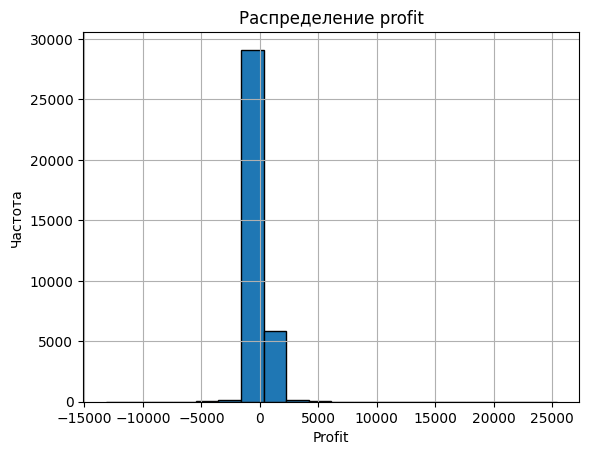

In [236]:
import matplotlib.pyplot as plt

# Гистограмма для 'profit'
df['profit'].hist(bins=20, edgecolor='black')
plt.title('Распределение profit')
plt.xlabel('Profit')
plt.ylabel('Частота')
plt.show()

График плотности (для непрерывных данных):  

Эти графики помогут вам визуализировать распределение значений в колонке profit и выявить возможные выбросы или аномалии.

C:\Users\Alkor\AppData\Local\Temp\ipykernel_9472\362401535.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['profit'], shade=True)


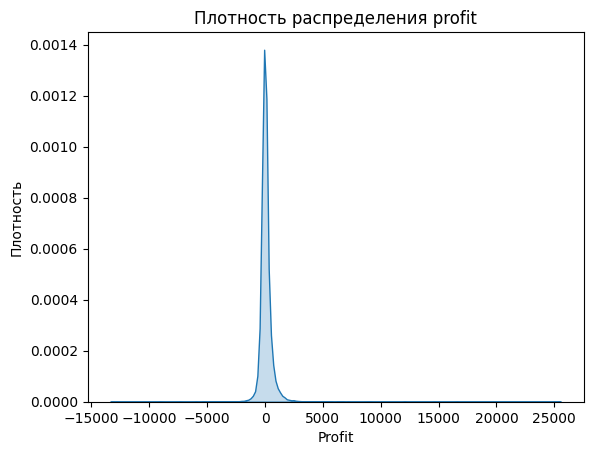

In [237]:
import seaborn as sns

# График плотности для 'profit'
sns.kdeplot(df['profit'], shade=True)
plt.title('Плотность распределения profit')
plt.xlabel('Profit')
plt.ylabel('Плотность')
plt.show()


### 4. Выявление выбросов:  
Можно использовать метод boxplot (диаграмма размаха), чтобы выявить выбросы в колонке profit.  

Диаграмма размаха поможет вам увидеть:

Медиану (в средней линии коробки).
Интерквартильный размах (между нижней и верхней границей коробки).
Потенциальные выбросы (точки за пределами «усов» коробки).

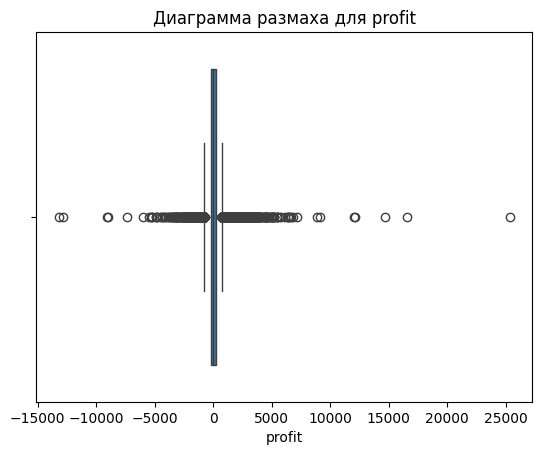

In [238]:
# Boxplot для 'profit'
sns.boxplot(x=df['profit'])
plt.title('Диаграмма размаха для profit')
plt.show()


# 5. Корреляция с другими колонками:
Если вы хотите проверить, есть ли какая-либо зависимость между колонкой profit и другими колонками, например, buy_sell, sig_open и т. д., можно использовать корреляцию или визуализировать зависимости.

Корреляция:

In [239]:
# Корреляция между 'profit' и другими колонками
correlation = df.corr()
print(correlation['profit'])


tradedate    0.004031
open         0.007168
high         0.007754
low          0.006009
close        0.006522
avg_per      0.000217
tvi         -0.002116
cci         -0.002116
t3          -0.002116
ghl         -0.002116
sig               NaN
sig_open     0.007168
buy_sell    -0.002116
profit       1.000000
Name: profit, dtype: float64


Это покажет, насколько сильно profit коррелирует с другими числовыми колонками в DataFrame.

Визуализация зависимости:

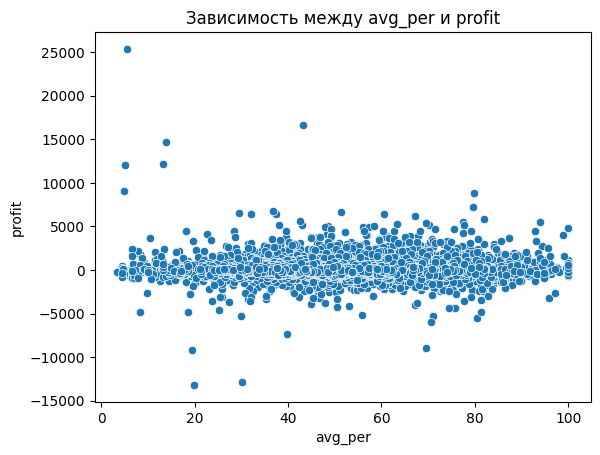

In [240]:
# С scatter plot для 'profit' и 'avg_per'
sns.scatterplot(x=df['avg_per'], y=df['profit'])
plt.title('Зависимость между avg_per и profit')
plt.xlabel('avg_per')
plt.ylabel('profit')
plt.show()
